In [1]:
import numpy as np
import random
import math
import os
import scipy.io#读取mat文件
import matplotlib.pyplot as plt#绘图
import torch#一个经典的对多维矩阵数据进行操作的张量（tensor ）库
import torch.nn as nn#神经网路工具箱，该工具箱建立于Autograd(主要有自动求导和梯度反向传播功能)，提供了网络搭建的模组，优化器等一系列功能
import torch.nn.functional as F#含了许多用于构建神经网络的函数，函数不具有可学习的参数。这些函数通常用于执行各种非线性操作、损失函数、激活函数等。
import torchvision#专门用来处理图像，通常用于计算机视觉领域
%matplotlib inline 

#内嵌绘图

from tqdm.notebook import tqdm#进度条库，可以在 Python 长循环中添加一个进度提示信息
from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error#MAE表示所有样本中，预测值与实际值之差的绝对值的平均值（平均绝对误差）
from sklearn.metrics import mean_squared_error#均方误差，预测值与实际值之差的平方的平均值（MSE）
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [2]:
def convert_to_time(hmm):#日期数据年月日时转换
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)
def loadMat(matfile):#读取mat文件并进行转化
    data = scipy.io.loadmat(matfile)#读取mat文件
    filename = matfile.split(".")[0]#以.切割，去掉.mat
    filename = filename.split("/")[-1]#将路径切割，得到数据集名称B0005等
    col = data[filename]
    col = col[0][0][0][0]#获取有效数据维度的数据
    size = col.shape[0]#数据维度
    data = []#用于存储读取的所需数据
    #col[i][0][0]为充放电和阻抗三类，col[i][1][0]为室温，col[i][2][0]为时刻，col[i][3][0]为数据
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())#获取电压电流等列名列表
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':#筛选非阻抗数据
            for j in range(len(k)):#获取有多少种数据特征
                t = col[i][3][0][0][j][0]#提取一种数据特征的所有数据
                l = [t[m] for m in range(len(t))]#用循环把该种数据特征转为列表
                d2[k[j]] = l#用字典d2存储一组包含所有数据特征的数据，电压对应电压数据等一组完整数据
        d1['type'], d1['temp'] = str(col[i][0][0]), int(col[i][1][0])
        d1['time'], d1['data'] = str(convert_to_time(col[i][2][0])), d2#用字典把所有数据存储
        data.append(d1)#最后用列表包装
    return data

In [3]:
# 提取锂电池容量
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':#先充电，后放电，为一个循环
            capacity.append(Bat['data']['Capacity'][0])#读取data数据中一次循环后每一组数据的容量
            cycle.append(i)#已进行的循环次数
            i += 1
    return [cycle, capacity]
 
 
# 获取锂电池充电或放电时的测试数据
def getBatteryValues(Battery, Type='charge'):#获取充电数据
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

In [4]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018'] # 4 个数据集的名字
capacity, charge, discharge = {}, {}, {}#存储电池容量、充电数据、放电数据
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = 'NASAdata/Battery1/'+name + '.mat'
    data = loadMat(path)
    capacity[name] = getBatteryCapacity(data)              # 放电时的容量数据
    charge[name] = getBatteryValues(data, 'charge')        # 充电数据
    discharge[name] = getBatteryValues(data, 'discharge')  # 放电数据

Load Dataset B0005.mat ...
Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


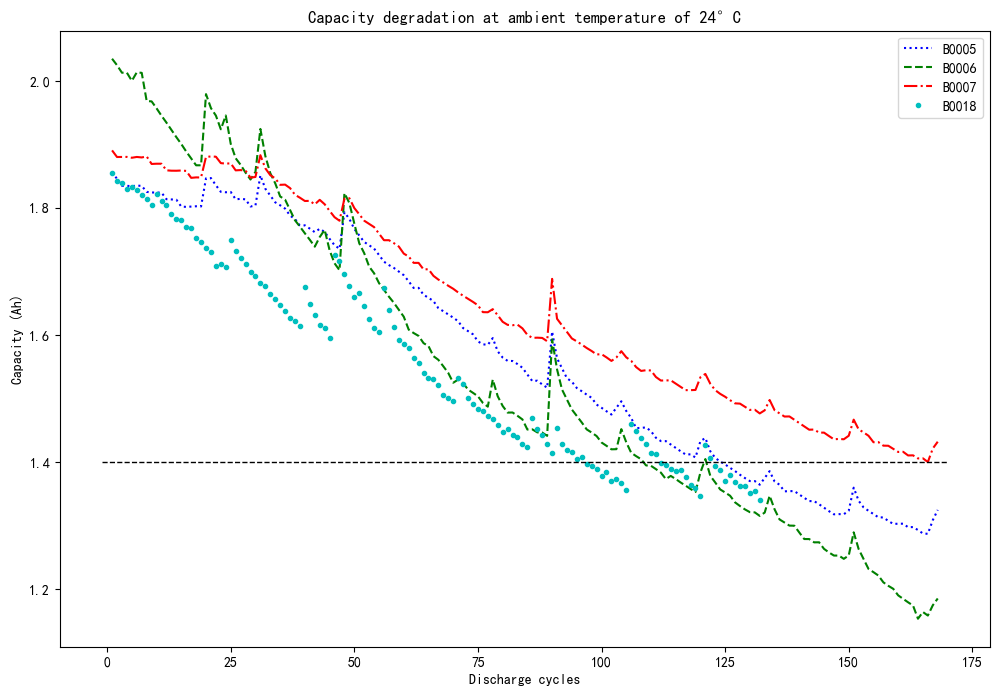

In [5]:
fig, ax = plt.subplots(1, figsize=(12, 8))#返回fig画窗和画窗中的坐标系ax
color_list = ['b:', 'g--', 'r-.', 'c.']#四种电池
c = 0
Battery={}
for name in Battery_list:
    da = capacity[name]#读取对应循环次数和容量
    color = color_list[c]
    ax.plot(da[0], da[1], color, label=name)#在ax以循环次数为x，容量为y画图
    c += 1
    Battery[name] = getBatteryCapacity(data)#用字典把每一种电池的容量和循环次数存储
plt.plot([-1,170],[2.0*0.7,2.0*0.7],c='black',lw=1,ls='--')  # 临界点直线
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

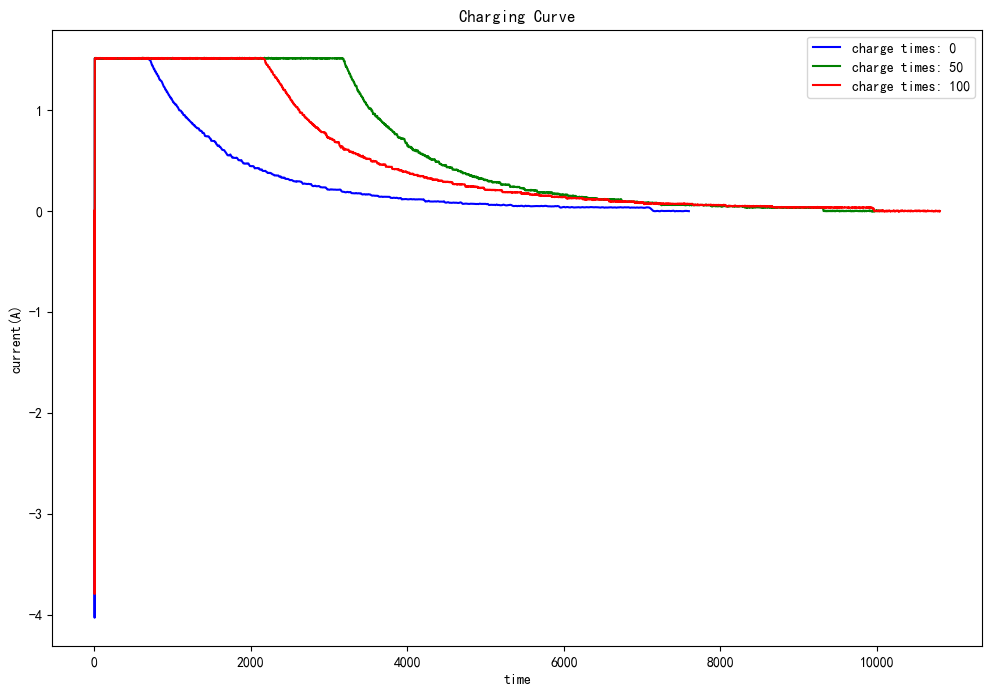

In [6]:
name = 'B0005'       #查看的电池号
times = [0, 50, 100] #查看的充电次数
 
# 画图
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b', 'g', 'r']
c = 0
for t in times:
    Bat = charge[name][t]#获取充电数据（循环次数为0，50，100三组数据）
    color = color_list[c]
    ax.plot(Bat['Time'], Bat['Current_measured'], color, label='charge times: '+str(t))#x为充电时间，y为测量电流
    c += 1
ax.set(xlabel='time', ylabel='current(A)', title='Charging Curve')
plt.legend()

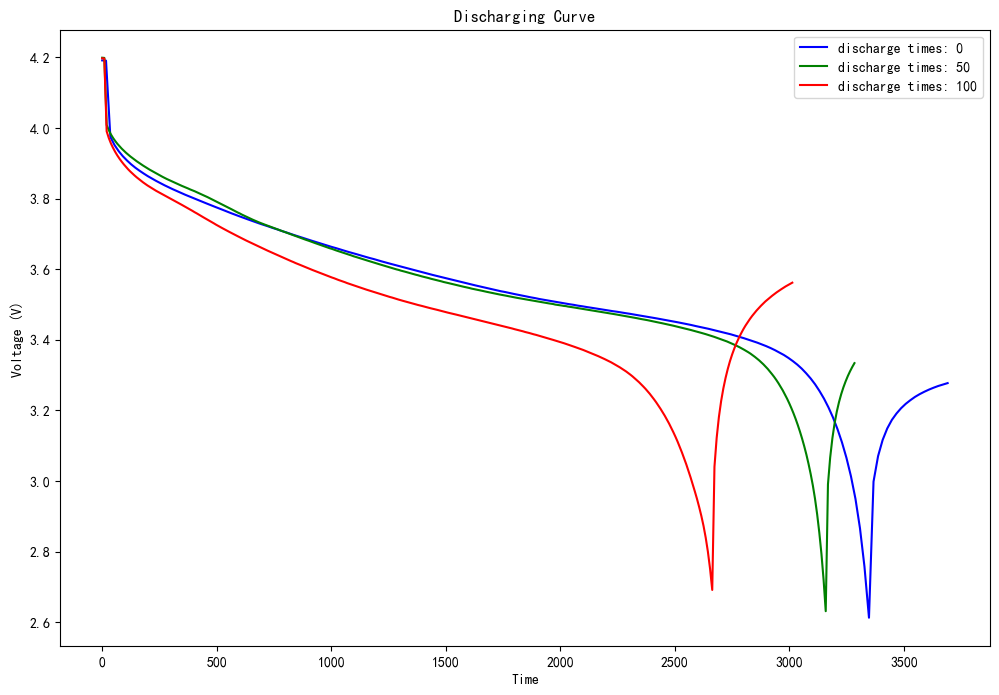

In [7]:
name = 'B0005'          #查看的电池号
times = [0, 50, 100]     #查看的放电次数
 
# 画图
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b', 'g', 'r']
c = 0
for t in times:
    Bat = discharge[name][t]
    color = color_list[c]
    ax.plot(Bat['Time'], Bat['Voltage_measured'], color, label='discharge times: '+str(t))
    c += 1
ax.set(xlabel='Time', ylabel='Voltage (V)', title='Discharging Curve')
plt.legend()

In [8]:
def build_instances(sequence, window_size):#采用一个长度为 window_size 的滑动窗口，从序列头部到尾部，每次移动 1 个数据，来截取需要的训练数据
    #sequence: 容量列表；
    x, y = [],[]
    for i in range(len(sequence) - window_size):#循环次数取决于可滑动次数
        features = sequence[i:i+window_size]
        target = sequence[i+window_size]

        x.append(features)
        y.append(target)
        
    return np.array(x).astype(np.float32), np.array(y).astype(np.float32)#astype用于将数组的数据类型转换为指定的类型

In [40]:
def get_train_test(data_dict, name, window_size=8):##留一个评估：随机抽取一个电池；其余的用于训练。
    data_sequence = data_dict[name][1]#按名称找到对应电池数据，[1]取容量数据
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]#把数据按窗口大小分为训练和测试
    train_x, train_y = build_instances(train_data, window_size)#用滑动窗口方法得到训练特征和标签
    for k, v in data_dict.items():#从字典中逐项取出，得到键和对应的值
        if k != name:
            data_x, data_y = build_instances(v[1], window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]   
    return train_x, train_y, list(train_data), list(test_data)

In [41]:
class Net(nn.Module):
    def __init__(self, hidden_dim=8, num_layers=1, mode='LSTM'):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.cell = nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        if mode == 'GRU':
            self.cell = nn.GRU(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif mode == 'RNN':
            self.cell = nn.RNN(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
 
    def forward(self, x):           # x shape: (batch_size, feature_size, 1)
        out, _ = self.cell(x)       # out shape: (batch_size, feature_size, hidden_dim)
        out = out[:, -1, :]         # 取序列最后一个时间步的输出作为预测  
        out = self.linear(out)      # out shape: (batch_size, 1)
        return out

In [42]:
# 定义创建模型的函数，用于GridSearchCV
def create_model(LSTM_units=50, learning_rate=0.001):
    model = Sequential()
    model.add(Bidirectional(LSTM(LSTM_units, return_sequences=True), input_shape=(1, X_train.shape[2])))
    model.add(Bidirectional(LSTM(LSTM_units)))
    model.add(Dense(1))  # 输出层
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [49]:
#Battery['B0005'][1]

In [44]:
def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse
def predict(w, X):
    probability = sigmoid(X * w.T)
    return [1 if x >= 0.5 else 0 for x in probability]

In [45]:
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
            
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
            
    score = abs(true_re - pred_re)/true_re
    if score > 1: score = 1
        
    return score

In [46]:
def train(lr, feature_size, hidden_dim=64, num_layers=2, weight_decay=0.0, mode='LSTM', epochs=1000, seed=0, device='cpu', metric='rmse'):
    score_list, result_list = [], []
    setup_seed(seed)
    for i in range(4):
        name = Battery_list[i]
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, feature_size)
        test_sequence = train_data + test_data
        test_x, test_y = build_instances(test_sequence, feature_size)
        # print('sample size: {}'.format(len(train_x)))
        
        model = Net(hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        loss_list, y_ = [0], []
        mae, rmse, re = 1, 1, 1
        score_, score = 1,1
        for epoch in range(epochs):
            X = np.reshape(train_x/Rated_Capacity,(-1, feature_size, 1))   # (batch_size, feature_size, 1)
            y = np.reshape(train_y/Rated_Capacity,(-1,1))          # shape 为 (batch_size, 1)

            X, y = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)
            output = model(X)
            output = output.reshape(-1, 1)
            loss = criterion(output, y)
            optimizer.zero_grad()            
            loss.backward()                    
            optimizer.step()                   

            if (epoch + 1) % 100 == 0:
                x = np.reshape(test_x/Rated_Capacity,(-1, feature_size, 1))
                x = torch.from_numpy(x).to(device) 
                pred = model(x) 
                point_list = pred.data.cpu().numpy() * Rated_Capacity
                point_list = point_list.reshape(-1)
                
                y_.append(point_list)                                 
                loss_list.append(loss)
                rmse = evaluation(y_test=test_y, y_predict=y_[-1])
                re = relative_error(y_test=test_y, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                #print('epoch:{:<2d} | loss:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, rmse, re))
            
            if metric == 're':
                score = [re]
            else:
                score = [rmse]
                
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()
            
        score_list.append(score_)
        result_list.append(train_data.copy()[:-1] + list(y_[-1]))
        
    return score_list, result_list

In [47]:
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) 
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [48]:
feature_size = 16
epochs = 500
lr = 0.001           # learning rate
hidden_dim = 128
num_layers = 1
weight_decay = 0.0
mode = 'LSTM'        # RNN, LSTM, GRU
Rated_Capacity = 2.0
metric = 'rmse'
device = 'cpu'

SCORE = []
for seed in tqdm(range(4)):
    print('seed: ', seed)
    score_list, _ = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                         weight_decay=weight_decay, mode=mode, epochs=epochs, seed=seed, device=device, metric=metric)
    print(np.array(score_list))
    print(metric + ': for this seed: {:<6.4f}'.format(np.mean(np.array(score_list))))
    for s in score_list:
        SCORE.append(s)
    print('------------------------------------------------------------------')
print(metric + ': mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))

  0%|          | 0/4 [00:00<?, ?it/s]

seed:  0
[[1.8550045 1.8431956 1.8396019 ... 1.7834707 1.7809386 1.771209 ]
 [1.8550045 1.8431956 1.8396019 ... 1.7834707 1.7809386 1.771209 ]
 [1.8431956 1.8396019 1.8306736 ... 1.7809386 1.771209  1.7686304]
 ...
 [1.3900461 1.3860271 1.3882153 ... 1.3686587 1.3627372 1.3634051]
 [1.3860271 1.3882153 1.3761827 ... 1.3627372 1.3634051 1.3518646]
 [1.3882153 1.3761827 1.3647169 ... 1.3634051 1.3518646 1.354797 ]]
[[1.8550045 1.8431956 1.8396019 ... 1.7834707 1.7809386 1.771209 ]
 [1.8550045 1.8431956 1.8396019 ... 1.7834707 1.7809386 1.771209 ]
 [1.8431956 1.8396019 1.8306736 ... 1.7809386 1.771209  1.7686304]
 ...
 [1.3900461 1.3860271 1.3882153 ... 1.3686587 1.3627372 1.3634051]
 [1.3860271 1.3882153 1.3761827 ... 1.3627372 1.3634051 1.3518646]
 [1.3882153 1.3761827 1.3647169 ... 1.3634051 1.3518646 1.354797 ]]
[[1.8550045 1.8431956 1.8396019 ... 1.7834707 1.7809386 1.771209 ]
 [1.8550045 1.8431956 1.8396019 ... 1.7834707 1.7809386 1.771209 ]
 [1.8431956 1.8396019 1.8306736 ... 1.780

In [18]:
seed = 0

feature_size = 16
epochs = 500
lr = 0.001           # learning rate
hidden_dim = 128
num_layers = 1
weight_decay = 0.0
mode = 'LSTM'        # RNN, LSTM, GRU
Rated_Capacity = 2.0
metric = 'rmse'
device = 'cpu'

SCORE = []
print('seed: ', seed)
score_list, prediction_list = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                                    weight_decay=weight_decay, mode=mode, epochs=epochs, seed=seed, device=device, metric=metric)

print(np.array(score_list))
print(metric + ' for this seed: {:<6.4f}'.format(np.mean(np.array(score_list))))

seed:  0
[[0.02995654]
 [0.0299247 ]
 [0.03036918]
 [0.02962145]]
rmse for this seed: 0.0300


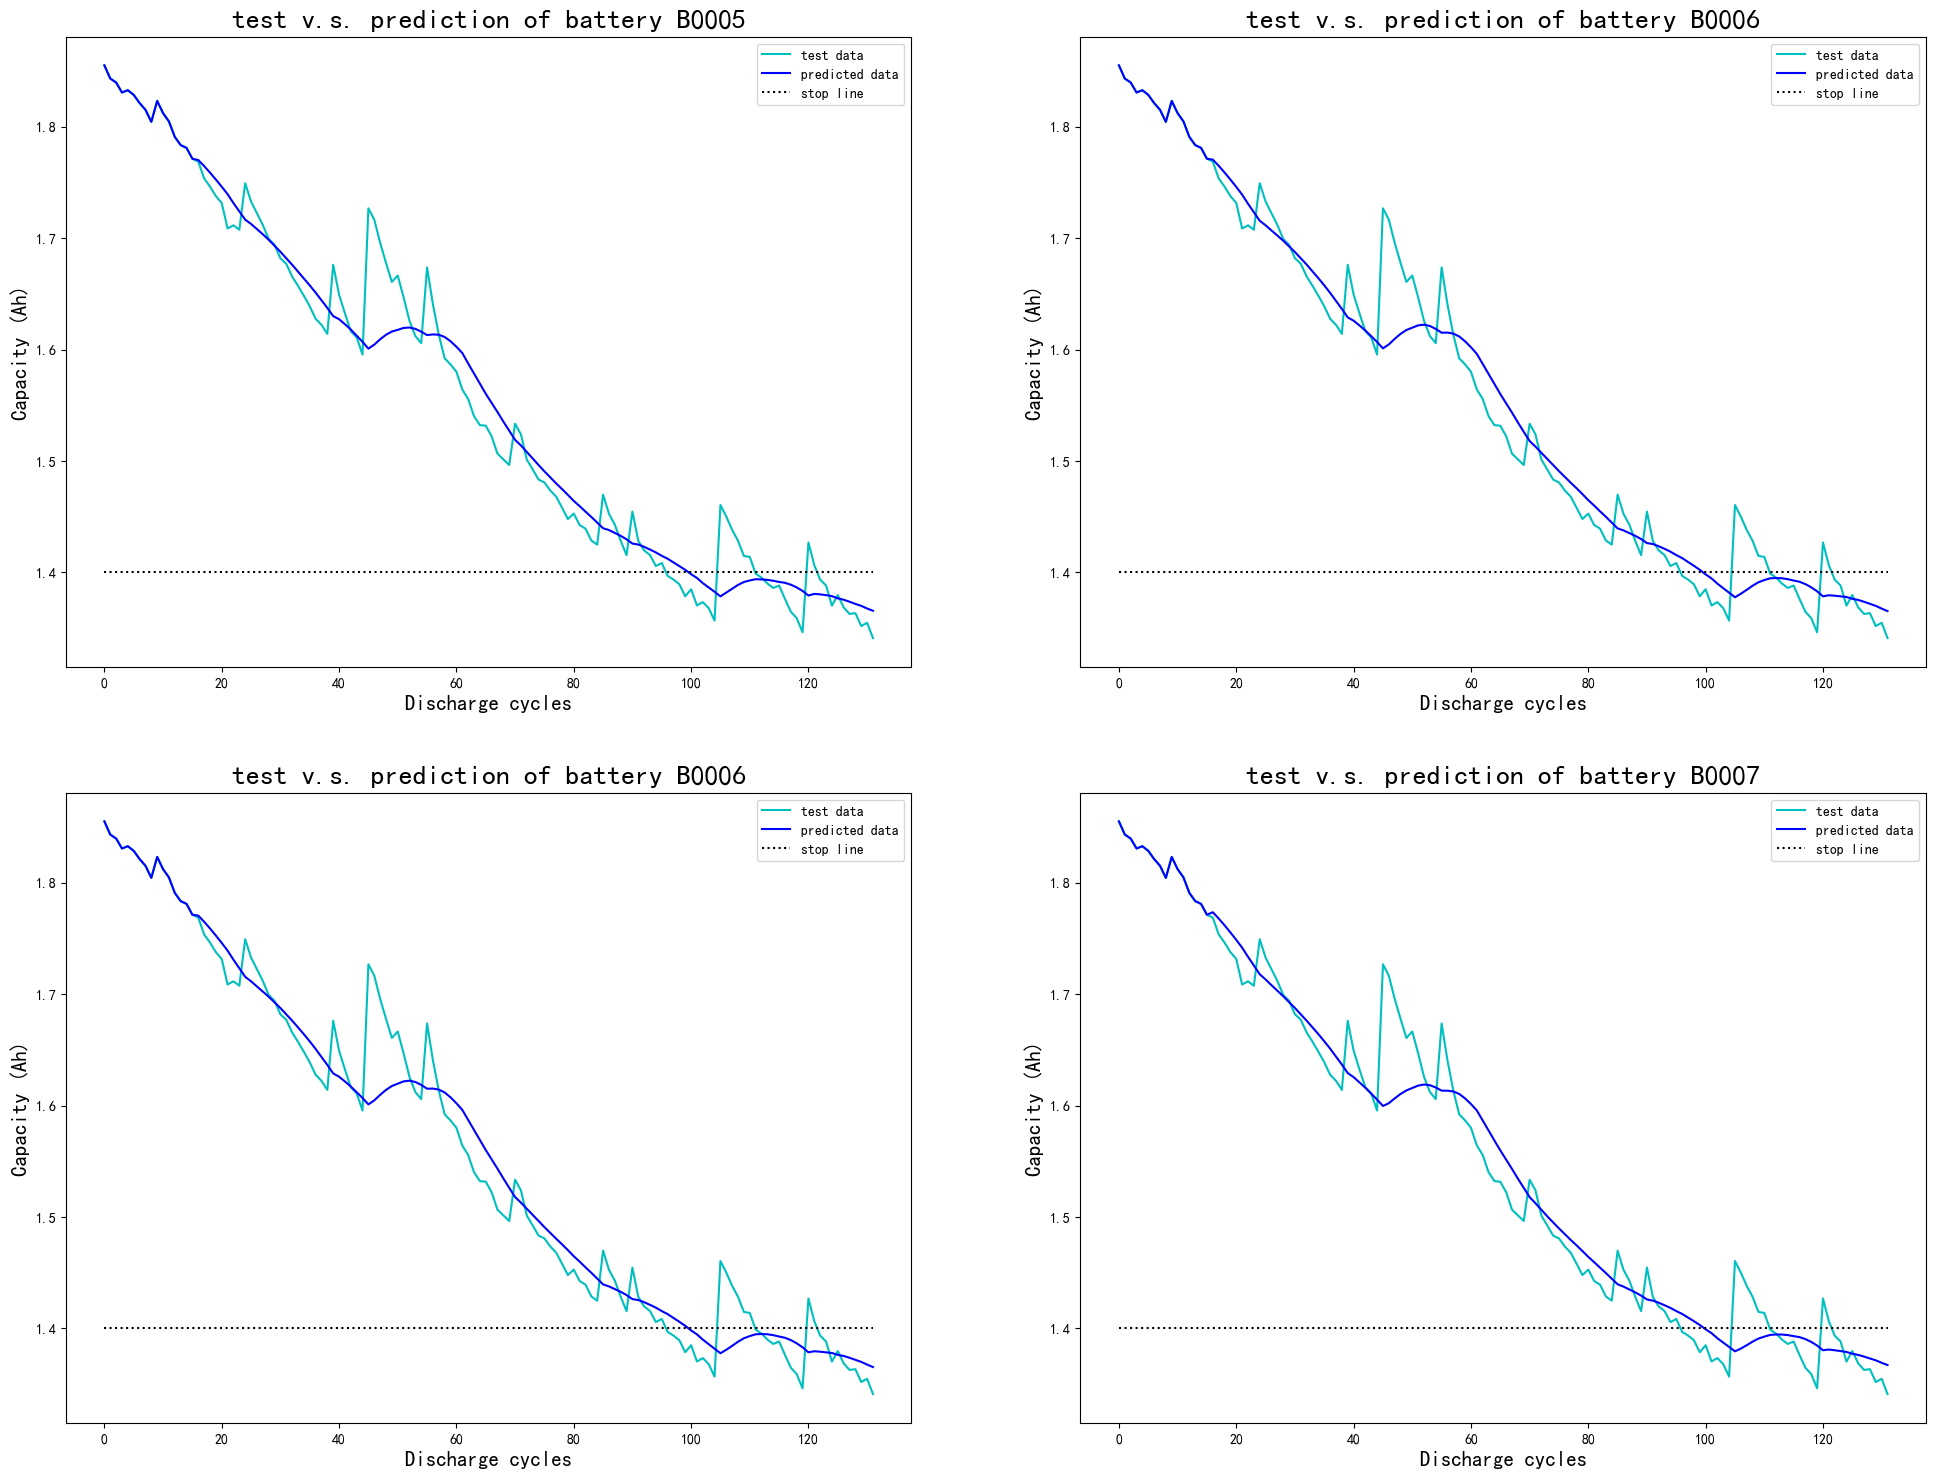

In [19]:
fig,ax = plt.subplots(2, 2, figsize=(24, 18))

for i in range(2):
    for j in range(2):
        t = i + j
        battery_name = Battery_list[t]
        test_data = Battery[battery_name][1]
        predict_data = prediction_list[t]
        x = [t for t in range(len(test_data))]
        threshold = [Rated_Capacity*0.7] * len(test_data)
        ax[i][j].plot(x, test_data, 'c', label='test data')
        ax[i][j].plot(x, predict_data, 'b', label='predicted data')
        ax[i][j].plot(x, threshold, 'black', ls=':', label='stop line')
        ax[i][j].legend()
        ax[i][j].set_xlabel('Discharge cycles', fontsize=15)
        ax[i][j].set_ylabel('Capacity (Ah)', fontsize=15)
        ax[i][j].set_title('test v.s. prediction of battery ' + battery_name, fontsize=20)
plt.show()

In [52]:
#没用到的函数
def split_dataset(data_sequence, train_ratio=0.0, capacity_threshold=0.0):
    if capacity_threshold > 0:
        max_capacity = max(data_sequence)
        capacity = max_capacity * capacity_threshold
        point = [i for i in range(len(data_sequence)) if data_sequence[i] < capacity]
    else:
        point = int(train_ratio + 1)
        if 0 < train_ratio <= 1:
            point = int(len(data_sequence) * train_ratio)
    train_data, test_data = data_sequence[:point], data_sequence[point:]
    
    return train_data, test_data